Convolution:
$$ \begin{align*}
    (f * g)(x) = \int_{-\infty}^{\infty} f(t) \, g(x - t) \, \mathrm{d}t && (1)\\
\end{align*} $$

Therefore:
$$ \begin{align*}
    (f * g)(0) = \int_{-\infty}^{\infty} f(t) \, g^{\vee}\!(t) \, \mathrm{d}t && (2)\\
\end{align*} $$

Retina image:
$$ \begin{align*}
    E(x_r) = \int_{-\infty}^{\infty} L(x_r, x_p) \, P(x_p) \, \mathrm{d}x_p = (L * P^{\vee})(x_r, 0) = (L * P)(x_r, 0) && (3)\\
\end{align*} $$

Signal analysis and synthesis:
$$ \begin{align*}
    \boldsymbol{c} &= \pmb{[} f * \psi \pmb{]} && (4)\\
    \tilde{f} &= \boldsymbol{c} * \varphi && (5)\\
\end{align*} $$

Orthogonal projection:
$$ \begin{align*}
    (f - \tilde{f}) \bot V_{\varphi} \iff \langle f - \tilde{f}, \varphi(\cdot - k) \rangle = 0 && \forall \, k \in \mathbb{Z} \iff \pmb{[} (f - \tilde{f}) * \varphi^{\vee} \pmb{]} = 0 && (6)\\
\end{align*} $$

From there:
$$ \begin{align*}
    \pmb{[} \tilde{f} * \varphi^{\vee} \pmb{]} &= \pmb{[} f * \varphi^{\vee} \pmb{]} \implies\\
    \pmb{[} \boldsymbol{c} * \varphi * \varphi^{\vee} \pmb{]} &= \pmb{[} f * \varphi^{\vee} \pmb{]} \implies\\
    \boldsymbol{c} * \pmb{[} \varphi * \varphi^{\vee} \pmb{]} &= \pmb{[} f * \varphi^{\vee} \pmb{]} \implies\\
    \boldsymbol{c} &= \pmb{[} f * \varphi^{\vee} \pmb{]} * \pmb{[} \varphi * \varphi^{\vee} \pmb{]}^{-1} && (7)\\
\end{align*} $$

But we have:
$$ \begin{align*}
    f &= (L * P)(x_r, 0) && (8)\\
    \tilde{f} &= (\tilde{L} * P)(x_r, 0) = (\boldsymbol{c} * D * P)(x_r, 0) && (9)\\
\end{align*} $$

In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
from cupyx.scipy import fft as cupyx_fft
from scipy import misc, fft as scipy_fft
import zarr
from matplotlib import pyplot, colors, cm
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display

In [2]:
cp.cuda.set_pinned_memory_allocator(None)
mempool = cp.get_default_memory_pool()

In [3]:
# Plot functions

colors.get_named_colors_mapping().update({
    'lfd:signal': "#4e79a7",
    'lfd:pupil': "#59a14f",
    'lfd:retina': "#e15759",
    'lfd:filter': "#f28e2b",
})



# Basic array functions

def sampling_lattice(res, pitch=1.0):
    """Return an array of shape (res,) containing the coordinates of a sampling lattice with a given pitch in "standard" order (with zero at the start)."""
    return scipy_fft.fftfreq(res).astype(np.float32) * (res * pitch)

def display_image(values, color_map=None, absolute=True, normalize=True, shift=False, flip=False):
    """Display an array as an image using a color map. The image can be normalized, shifted and/or flipped."""
    values = np.abs(values) if absolute else values
    values = values * np.nan_to_num(1.0 / np.amax(values)) if normalize else values
    values = scipy_fft.fftshift(values) if shift else values
    values = np.flip(values) if flip else values
    color_values = cm.get_cmap(color_map)(values, bytes=True)
    display(Image.fromarray(color_values).transpose(Image.ROTATE_90))



# Spatial and spectral transformations between the display and the eye spaces

def x_ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f):
    """Return the position on the retina from the positions on the display layers."""
    return (1 - z_b/z_f) * z_r/(z_a - z_b) * x_a + (1 - z_a/z_f) * z_r/(z_b - z_a) * x_b

def x_ab_to_p(x_a, x_b, z_a, z_b):
    """Return the position on the pupil from the positions on the display layers."""
    return z_b/(z_b - z_a) * x_a + z_a/(z_a - z_b) * x_b

def x_rp_to_a(x_r, x_p, z_r, z_a, z_f):
    """Return the position on the display layer A from the positions on the retina and pupil."""
    return (z_a/z_r) * x_r + (1 - z_a/z_f) * x_p

def x_rp_to_b(x_r, x_p, z_r, z_b, z_f):
    """Return the position on the display layer B from the positions on the retina and pupil."""
    return (z_b/z_r) * x_r + (1 - z_b/z_f) * x_p

def xi_ab_to_r(xi_a, xi_b, z_r, z_a, z_b):
    """Return the frequency on the retina from the frequencies on the display layers."""
    return (z_a/z_r) * xi_a + (z_b/z_r) * xi_b

def xi_ab_to_p(xi_a, xi_b, z_a, z_b, z_f):
    """Return the frequency on the pupil from the frequencies on the display layers."""
    return (1 - z_a/z_f) * xi_a + (1 - z_b/z_f) * xi_b

def xi_rp_to_a(xi_r, xi_p, z_r, z_a, z_b, z_f):
    """Return the frequency on the display layer A from the frequencies on the retina and pupil."""
    return (1 - z_b/z_f) * z_r/(z_a - z_b) * xi_r + z_b/(z_b - z_a) * xi_p

def xi_rp_to_b(xi_r, xi_p, z_r, z_a, z_b, z_f):
    """Return the frequency on the display layer B from the frequencies on the retina and pupil."""
    return (1 - z_a/z_f) * z_r/(z_b - z_a) * xi_r + z_a/(z_a - z_b) * xi_p



# Interval functions

def intersect(*intervals):
    """Return the intersection of intervals of shape [2,...] where the first dimension is [lower, upper]."""
    result = intervals[0]
    for interval in intervals[1:]:
        result = np.clip(result, interval[0], interval[1])
    return result



# Indefinite integrals (antiderivatives) of kernels

def integral_DPP(x, x_p, w_p):
    c0 = 1 + x_p/w_p
    c1 = -1/w_p
    return x * c0 + np.square(x) * (c1/2)

def integral_DDPP(x, x_r, x_p, z_r, z_a, z_b, z_f, w_p, w_a, w_b):
    ca0 = (w_a - x_r * z_a/z_r)/w_a
    ca1 = (z_a/z_f - 1)/w_a
    cb0 = (w_b - x_r * z_b/z_r)/w_b
    cb1 = (z_b/z_f - 1)/w_b
    cp0 = 1 + x_p/w_p
    cp1 = -1/w_p
    c0 = ca0 * cb0 * cp0
    c1 = (ca1 * cb0 * cp0) + (ca0 * cb1 * cp0) + (ca0 * cb0 * cp1)
    c2 = (ca0 * cb1 * cp1) + (ca1 * cb0 * cp1) + (ca1 * cb1 * cp0)
    c3 =  ca1 * cb1 * cp1
    return x * c0 + np.square(x) * (c1/2) + np.power(x, 3) * (c2/3) + np.power(x, 4) * (c3/4)

In [4]:
z_r = -17.0
z_a = 10.0
z_b = 30.0

pupil_diameter = 5.0

size_r = 5.5
size_a = size_r * z_a / abs(z_r) + 2*pupil_diameter
size_b = size_r * z_b / abs(z_r) + 2*pupil_diameter

res_r = 375
res_a = 81
res_b = 81

pitch_r = size_r / res_r
pitch_a = size_a / res_a
pitch_b = size_b / res_b

oversampling = 9

res_A = res_a * oversampling
res_B = res_b * oversampling
pitch_A = size_a / res_A
pitch_B = size_b / res_B

w_a = pitch_a
w_b = pitch_b
w_p = pupil_diameter

z_f = 10000.0

P:


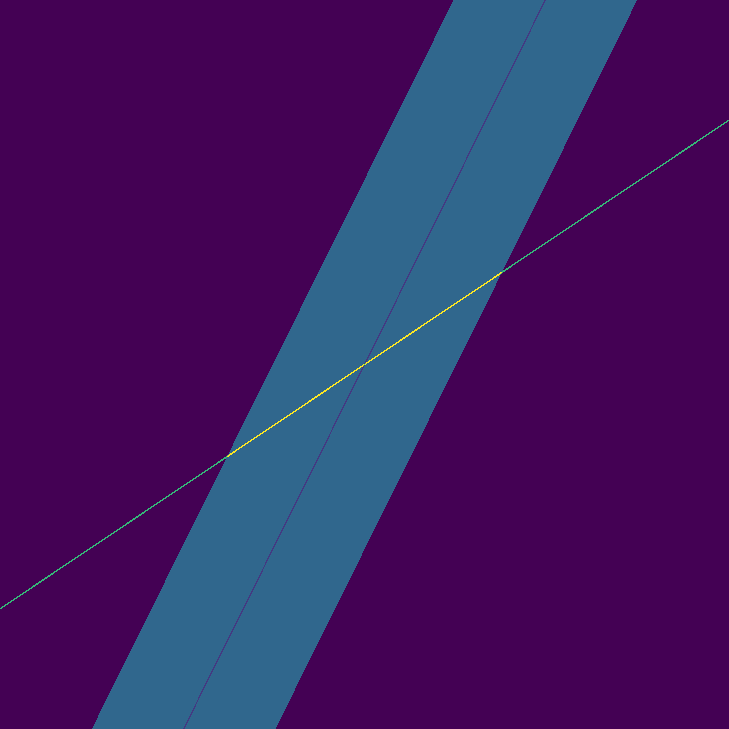

D:


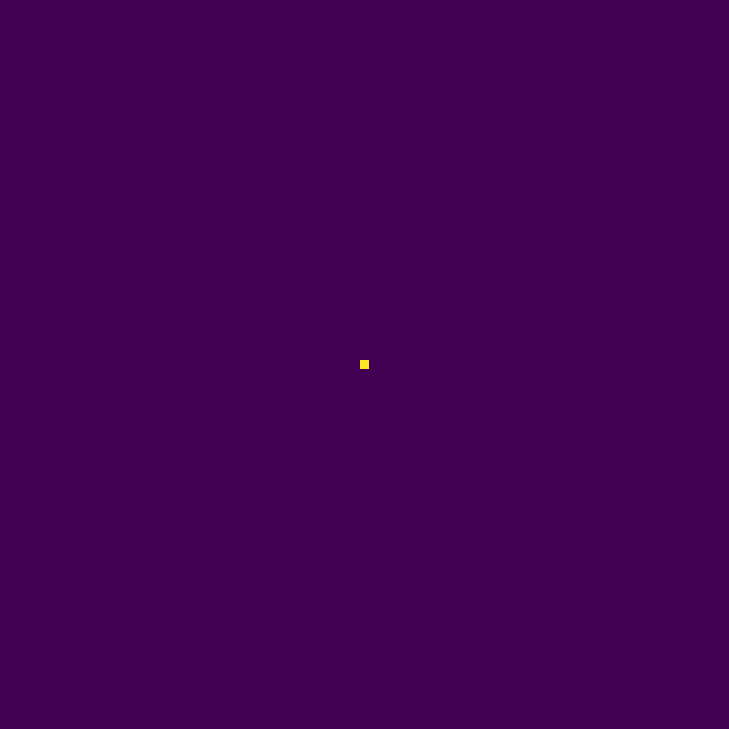

D * P:


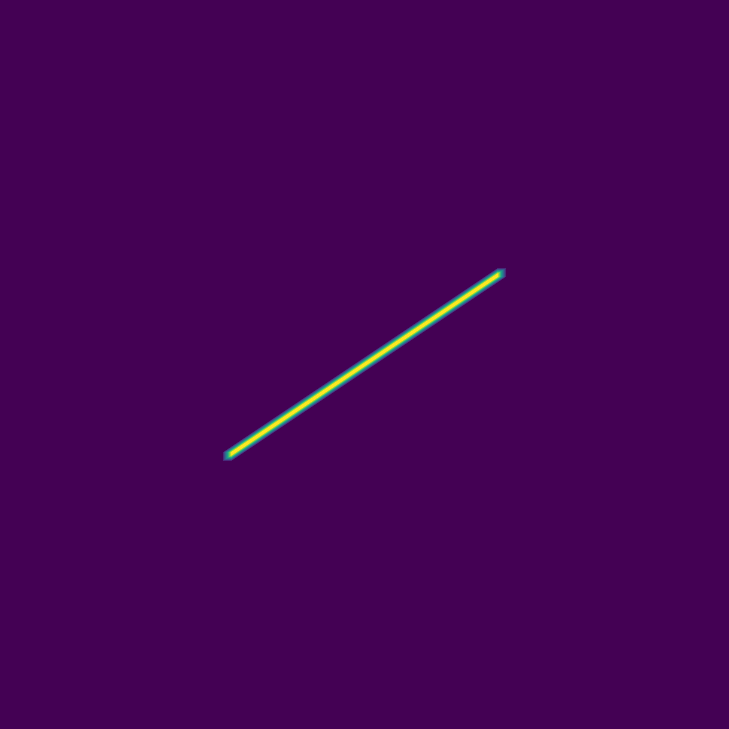

D * P * P:


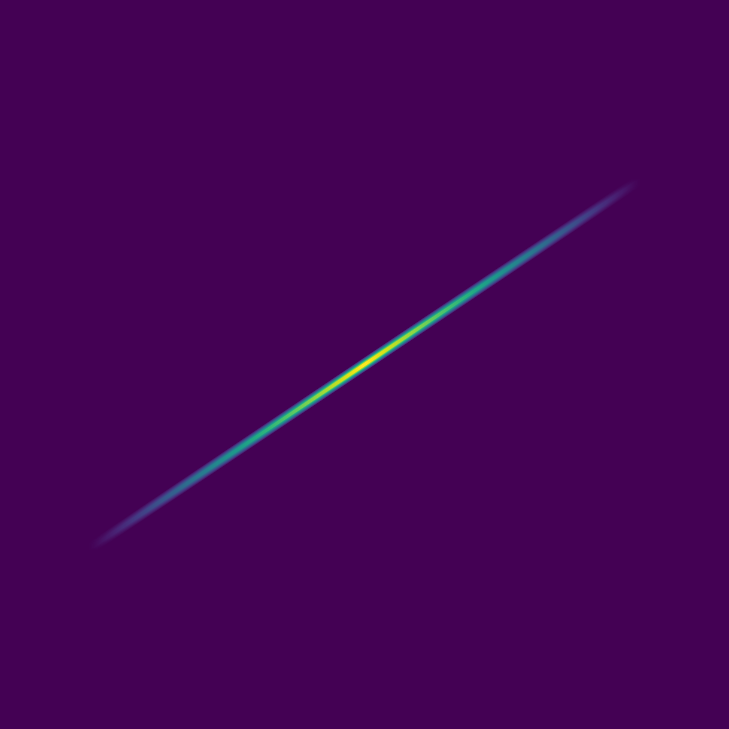

D * D * P * P:


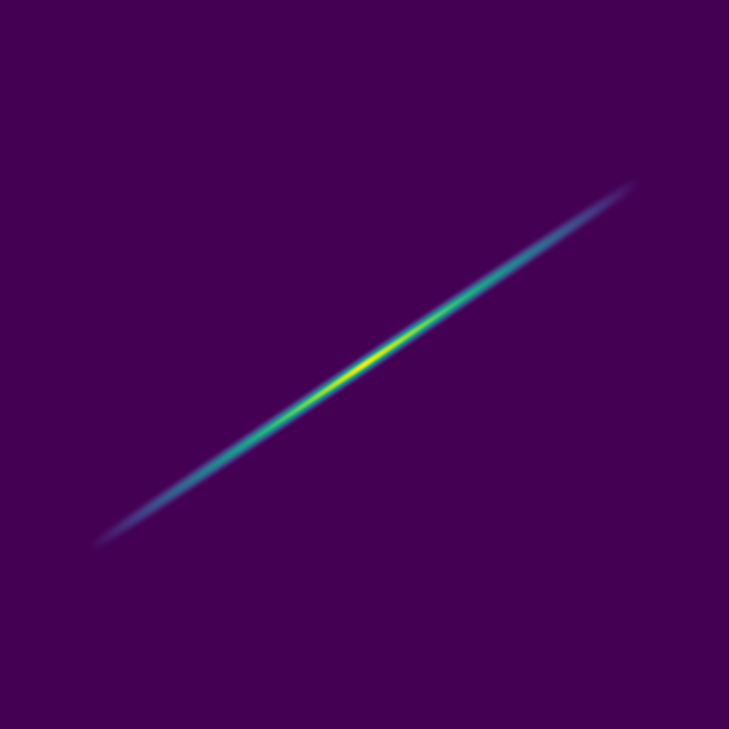

F{D * D * P * P}:


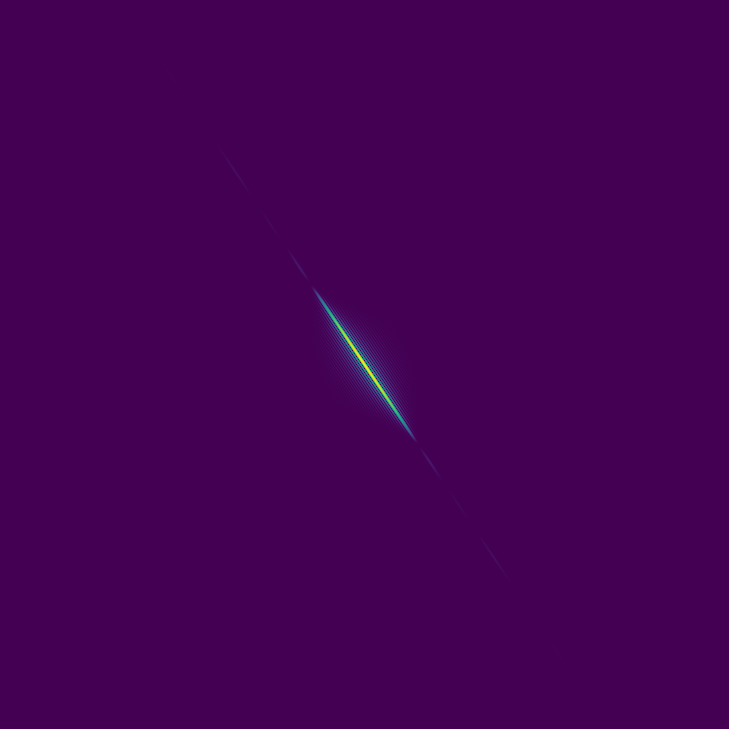

In [5]:
x_a_over_AB = sampling_lattice(res_A, pitch_A)[:, np.newaxis]
x_b_over_AB = sampling_lattice(res_B, pitch_B)[np.newaxis, :]

phi_D_over_AB = np.logical_and(np.abs(x_a_over_AB) < w_a/2, np.abs(x_b_over_AB) < w_b/2)

x_r_over_AB = x_ab_to_r(x_a_over_AB, x_b_over_AB, z_r, z_a, z_b, z_f)
x_p_over_AB = x_ab_to_p(x_a_over_AB, x_b_over_AB, z_a, z_b)

x_p_over_P5_AB = x_p_over_AB + np.array([-1.0, -0.5, 0.0, 0.5, 1.0])[:, np.newaxis, np.newaxis] * w_p

x_p_over_A5_AB = x_r_over_AB * (z_a/z_r)/(z_a/z_f - 1) + np.array([-1.0, -0.5, 0.0, 0.5, 1.0])[:, np.newaxis, np.newaxis] * w_a / abs(z_a/z_f - 1)
x_p_over_B5_AB = x_r_over_AB * (z_b/z_r)/(z_b/z_f - 1) + np.array([-1.0, -0.5, 0.0, 0.5, 1.0])[:, np.newaxis, np.newaxis] * w_b / abs(z_b/z_f - 1)

x = intersect(x_p_over_A5_AB[(1, 3),], x_p_over_B5_AB[(1, 3),], x_p_over_P5_AB[(1, 3),])
phi_DP_over_AB = np.tensordot([-1, 1], x, axes=1)

x = intersect(x_p_over_P5_AB[(2, 4),], x_p_over_A5_AB[(1, 3),], x_p_over_B5_AB[(1, 3),])
phi_DPP_over_AB = np.tensordot([-1, 1], integral_DPP(x, x_p_over_AB, w_p), axes=1)
x = intersect(x_p_over_P5_AB[(0, 2),], x_p_over_A5_AB[(1, 3),], x_p_over_B5_AB[(1, 3),])
phi_DPP_over_AB += np.tensordot([-1, 1], integral_DPP(x, x_p_over_AB, -w_p), axes=1)

x = intersect(x_p_over_P5_AB[(2, 4),], x_p_over_A5_AB[(2, 4),], x_p_over_B5_AB[(2, 4),])
phi_DDPP_over_AB = np.tensordot([-1, 1], integral_DDPP(x, x_r_over_AB, x_p_over_AB, z_r, z_a, z_b, z_f, w_p, w_a, w_b), axes=1)
x = intersect(x_p_over_P5_AB[(0, 2),], x_p_over_A5_AB[(2, 4),], x_p_over_B5_AB[(2, 4),])
phi_DDPP_over_AB += np.tensordot([-1, 1], integral_DDPP(x, x_r_over_AB, x_p_over_AB, z_r, z_a, z_b, z_f, -w_p, w_a, w_b), axes=1)
x = intersect(x_p_over_P5_AB[(2, 4),], x_p_over_A5_AB[(0, 2),], x_p_over_B5_AB[(2, 4),])
phi_DDPP_over_AB += np.tensordot([-1, 1], integral_DDPP(x, x_r_over_AB, x_p_over_AB, z_r, z_a, z_b, z_f, w_p, -w_a, w_b), axes=1)
x = intersect(x_p_over_P5_AB[(0, 2),], x_p_over_A5_AB[(0, 2),], x_p_over_B5_AB[(2, 4),])
phi_DDPP_over_AB += np.tensordot([-1, 1], integral_DDPP(x, x_r_over_AB, x_p_over_AB, z_r, z_a, z_b, z_f, -w_p, -w_a, w_b), axes=1)
x = intersect(x_p_over_P5_AB[(2, 4),], x_p_over_A5_AB[(2, 4),], x_p_over_B5_AB[(0, 2),])
phi_DDPP_over_AB += np.tensordot([-1, 1], integral_DDPP(x, x_r_over_AB, x_p_over_AB, z_r, z_a, z_b, z_f, w_p, w_a, -w_b), axes=1)
x = intersect(x_p_over_P5_AB[(0, 2),], x_p_over_A5_AB[(2, 4),], x_p_over_B5_AB[(0, 2),])
phi_DDPP_over_AB += np.tensordot([-1, 1], integral_DDPP(x, x_r_over_AB, x_p_over_AB, z_r, z_a, z_b, z_f, -w_p, w_a, -w_b), axes=1)
x = intersect(x_p_over_P5_AB[(2, 4),], x_p_over_A5_AB[(0, 2),], x_p_over_B5_AB[(0, 2),])
phi_DDPP_over_AB += np.tensordot([-1, 1], integral_DDPP(x, x_r_over_AB, x_p_over_AB, z_r, z_a, z_b, z_f, w_p, -w_a, -w_b), axes=1)
x = intersect(x_p_over_P5_AB[(0, 2),], x_p_over_A5_AB[(0, 2),], x_p_over_B5_AB[(0, 2),])
phi_DDPP_over_AB += np.tensordot([-1, 1], integral_DDPP(x, x_r_over_AB, x_p_over_AB, z_r, z_a, z_b, z_f, -w_p, -w_a, -w_b), axes=1)

hatphi_DDPP_over_AB = scipy_fft.fft2(phi_DDPP_over_AB)

print('P:')
display_image((np.abs(x_p_over_AB) < pupil_diameter/2) + 2*(np.abs(x_r_over_AB) < 0.02) - 0.5*(np.abs(x_p_over_AB) < 0.02), normalize=True, shift=True)
print('D:')
display_image(phi_D_over_AB, shift=True)
print('D * P:')
display_image(phi_DP_over_AB, shift=True)
print('D * P * P:')
display_image(phi_DPP_over_AB, shift=True)
print('D * D * P * P:')
display_image(phi_DDPP_over_AB, shift=True)
print('F{D * D * P * P}:')
display_image(np.log(1.0 + np.abs(hatphi_DDPP_over_AB)), shift=True)